In [1]:
from PIL import Image
import numpy as np, PIL, pandas as pd, json, re, pickle, os
from hashlib import sha1 as hash_fn

import matplotlib.pyplot as plt

from time import time, localtime, asctime, ctime

from ipywidgets import FloatProgress
from IPython.display import Markdown, DisplayHandle

from stat import S_ISREG, ST_CTIME, ST_MODE

In [2]:
start = 20
end = 40

step_size=20

chunk_file_suffix = [i for i in range(start, end, step_size)]

base_path = "../"

data_dir = "data/intermediate/"
chunking = "chunking/"
hashes = "hashes/"
csvs = "csvs/"

base_mnist_path = base_path+"mnist/"
by_field_dir = "by_field/"

In [3]:
def read_hash_pickle(filename):
    """
        Read a pickled img hash dictionary, requires filename
        returns image hash based dictionary
    """
    file = open(filename, "rb")
    img_hash_dict = pickle.loads(file.read())
    file.close()
    return img_hash_dict

In [4]:
#get newest filename
def get_newest_pickle():
    path = data_dir+hashes

    hash_pickles = os.listdir(path)

    pickle_stats = {os.stat(path+pickle)[ST_CTIME]:path+pickle for pickle in hash_pickles}
    display(pickle_stats)
    pickle_key_list = [key for key in pickle_stats.keys()]

    pickle_key_list.sort(reverse=True)

    pickle_path = None
    reloaded = None

    start_file = 0

    if len(pickle_key_list)>0:
        pickle_path = pickle_stats[pickle_key_list[0]]
        pickle_name_split = re.split(r"_([0-9]+)", pickle_path)
        start_file = int(pickle_name_split[-2])

    display(Markdown("Loading Img Hash Pickle for {} processed files".format(start_file)))
    
    if pickle_path is not None:
        reloaded = read_hash_pickle(pickle_path)
        
    return reloaded

In [ ]:
img_hash_dict = get_newest_pickle()

{1551848557: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_21.01.19_2019_790000.pickle.zip',
 1551848627: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_21.03.47_2019_810000.pickle',
 1551849413: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_21.16.53_2019_all.pickle',
 1551850193: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_21.16.53_2019_all.pickle.zip',
 1551852012: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_22.00.12_2019_all.pickle',
 1551852031: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_22.00.31_2019_all.pickle',
 1551852345: 'data/intermediate/hashes/by_field_openssl_sha1_Tue_Mar__5_22.05.45_2019_all.pickle'}

Loading Img Hash Pickle for 2019 processed files

In [ ]:
def get_hash(filename):
    """
        Calc hash of file given a filename
        filename: file to hash
        returns hexdigest hash
    """
    
    from pathlib import Path
    
    if not Path(filename):
        raise ValueError("{} does not exist".format(filename))
    
    this_hasher = hash_fn()
            
    with open(filename, "rb") as img:
        
        this_hasher.update(img.read())

    img.close()

    return this_hasher.hexdigest()

In [ ]:
orig_file_hash = get_hash("../mnist/by_field/hsf_0/digit/30/30_00000.png")
match_file_hash = get_hash("../mnist/by_write/hsf_0/f0000_14/d0000_14/d0000_14_00000.png")

display(orig_file_hash == match_file_hash)


entry = img_hash_dict[orig_file_hash]
display(entry)
display(img_hash_dict[match_file_hash])

display(Markdown("{}".format(chr(int(entry["char_label"], 16)))))

display(len(img_hash_dict.keys()))


True

{'file_path': '../mnist/by_field/hsf_0/digit/30/30_00000.png',
 'char_label': '30'}

{'file_path': '../mnist/by_field/hsf_0/digit/30/30_00000.png',
 'char_label': '30'}

0

814244

In [ ]:
by_writer_dir = "by_write/"

this_hash = hash_fn()

with open(base_mnist_path+by_writer_dir+"hsf_0/f0000_14/c0000_14/c0000_14_00000.png", "rb") as test:    
    data = test.read()
    this_hash.update(data)
    
digest = this_hash.hexdigest()
    
if digest in img_hash_dict.keys():
    entry = img_hash_dict[digest]
    display(entry)
    code = int(entry["char_label"], 16)
    display(Markdown("This is an image of the character with code 0x{:x} which is \"{}\"".format(code, chr(code))))
else:
    display("Test image not found!")
    
# if digest in reloaded.keys():
#     entry = reloaded[digest]
#     display(entry)
#     code = int(entry["char_label"], 16)
#     display(Markdown("This is an image of the character with code 0x{:x} which is \"{}\"".format(code, chr(code))))
# else:
#     display("Test image not found!")

{'file_path': '../mnist/by_field/hsf_0/const/57/57_00000.png',
 'char_label': '57'}

This is an image of the character with code 0x57 which is "W"

FloatProgress(value=0.0, max=500.0)

## Currently Processing

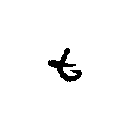

Adding pandas row...  **writer**: 0000  **label**: t

In [ ]:
df = pd.DataFrame(columns=[i for i in range((128**2))]+["image", "label", "writer_id"])

downsample_factor = 1 #start with no downsampling

#im = Image.open(file)
#ih = IPython.display.Image(data=im)
#display(ih)

fp = FloatProgress(min=0, max=500)
display(fp)

display(Markdown("## Currently Processing"))
dh_img = DisplayHandle()
dh_img.display(Markdown("Begin"))

dh_stage = DisplayHandle()
dh_stage.display(Markdown("Begin"))

for suffix in chunk_file_suffix:
    dh_stage.update(Markdown("Loading Chunk file..."))
    chunk_file = data_dir+chunking+"all_by_write_files_{}.json".format(suffix)
    
    json_file = open(chunk_file)
    
    chunk_dict = json.loads(json_file.read())

    for key, writer_char in chunk_dict.items():
        #display(key, writer_char)
        for file in writer_char["files"]:
            writer_id = writer_char["writer_id"]
            dh_stage.update(Markdown("Loading Image file...\n writer {}".format(writer_id)))
            #display(file)
            
            
            
            digest = get_hash(file)
            
            dh_stage.update(Markdown("Got image file hash...\n writer {}".format(writer_id)))
            
            code_label = None
            
            entry = None
            try:
                entry = img_hash_dict[digest]
                #display(entry)
                code_label = chr(int(entry["char_label"], 16))
                dh_stage.update(Markdown("Found matchig image file hash...\n writer {}".format(writer_id)))
            except KeyError as e:
                display(Markdown("hash for {} not found!".format(file)))
                continue

            dh_stage.update(Markdown("Processing Image file...\n writer: {}\n label: {}".format(writer_id, code_label)))
            
            im = Image.open(file)
            dh_img.update(im)
            
            bit2 = im.convert("P", palette=Image.ADAPTIVE, colors=256)
            x = int(im.width/downsample_factor)  # 128
            y = int(im.height/downsample_factor) # 128
            bit2xy = bit2.resize((x, y), resample=PIL.Image.LANCZOS)
            
            data = bit2xy.getdata()
            
            arr = np.array(data)
            arr = arr.reshape((x, y))
            
            dh_stage.update(Markdown("Making pandas row...\n writer: {}\n label: {}".format(writer_id, code_label)))
            
            row = {"image":arr, "label": code_label, "writer_id":writer_id}
            
            row_w_pixel_cols = {index_1d: pixel for index_1d, pixel in enumerate(arr)}
            
            for k, v in row.items():
                row_w_pixel_cols[k] = v
            
            dh_stage.update(Markdown("Adding pandas row...  **writer**: {}  **label**: {}".format(writer_id, code_label)))
            df.append(row_w_pixel_cols, ignore_index=True)
            fp.value += 1


In [ ]:
df

In [ ]:
df.to_csv(data_dir+csvs+"mnist_chunks_"+str(start)+"_to_"+str(end)+".csv")